# MCMC Techniques with `pymc3`

`PyMC` is a useful module to know for reasons beyond Bayesian Linear Regression, given its implementation of MCMC. 

Instead of solving our Bayesian Regression problem directly, `pymc3` instead uses Markov Chain Monte Carlo techniques to estimate regression parameters.    

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  

import pymc3 as pm

In [29]:
### Read in the data
tr_path = 'train.csv'
data = pd.read_csv(tr_path)  

### The .head() function shows the first few lines of data for perspecitve
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


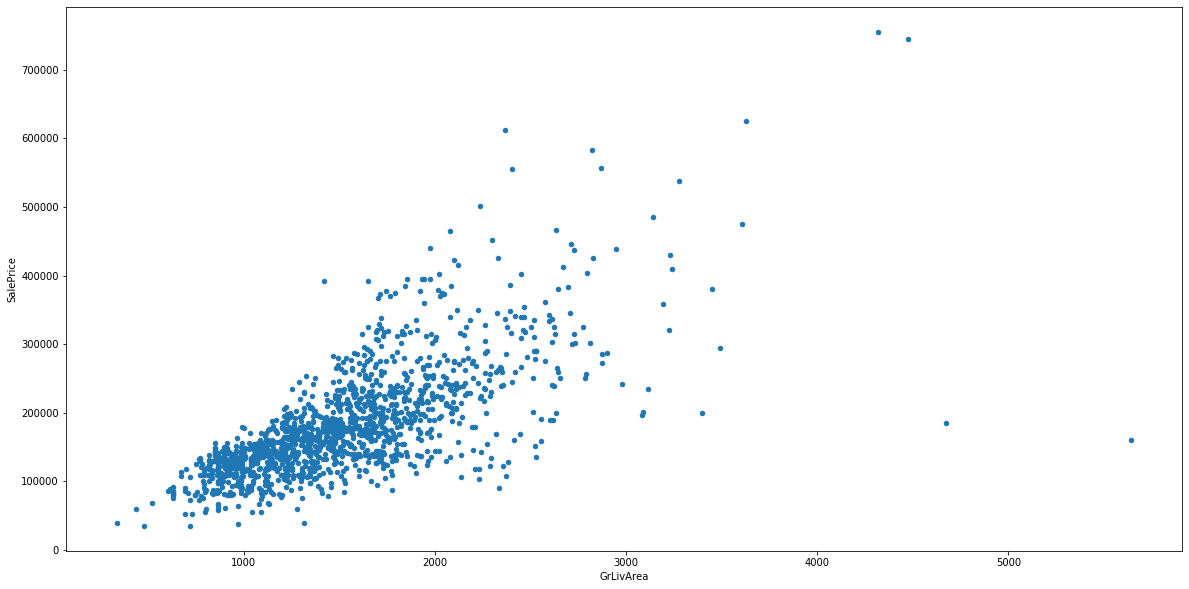

In [30]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'o');

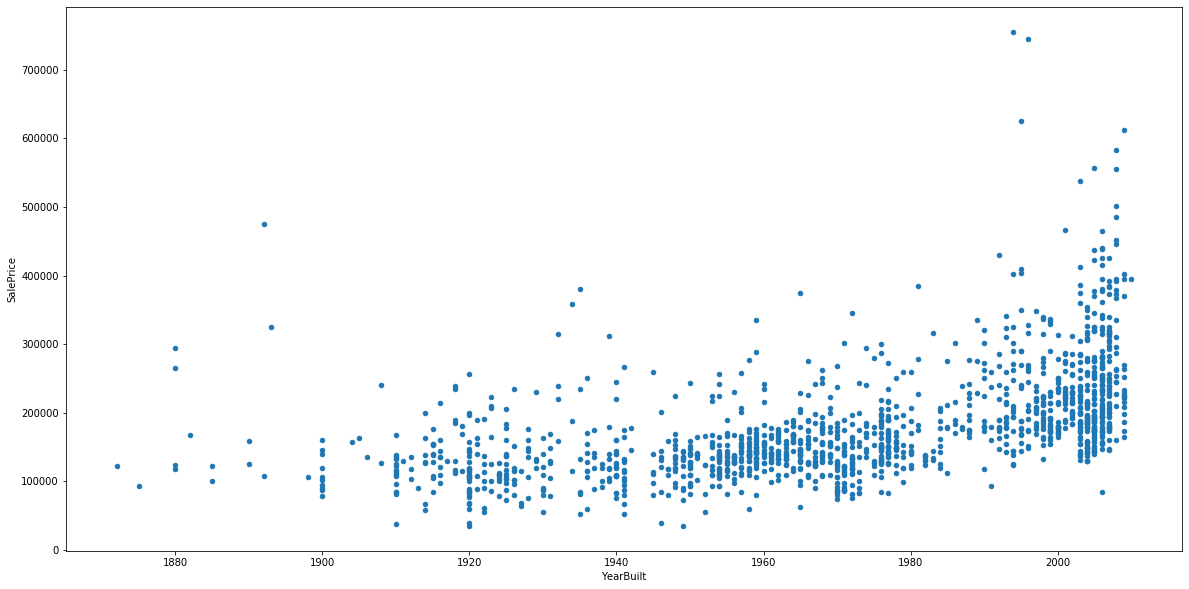

In [31]:
data.plot('YearBuilt', 'SalePrice', kind = 'scatter', marker = 'o')

# Creating Data

In order to correspond to the `pymc3` model structure. We generate artificial (synthetic) data in order to recover the parameters when using `pymc3`. 

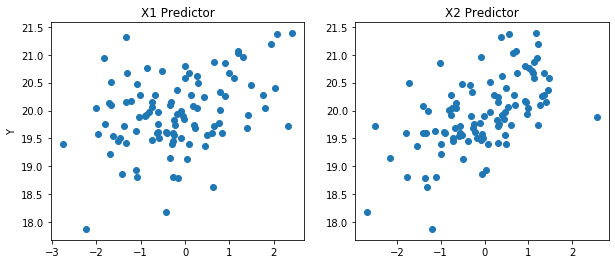

In [32]:
np.random.seed(1738)

# Create True parameters:
intercept, sigma, betas = 20, .5, np.array([0.2, .4])

# set number of observations
obs = 100

predictors = np.random.randn(obs, 2)

# Defining our explicit linear relationship. Notice how the noise is added with `sigma`
Y = intercept + np.matmul(predictors, betas) + np.random.randn(obs)*sigma


# visualize predictors against the actual values
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(predictors[:,0], Y)
plt.title("X1 Predictor")
plt.ylabel("Y")
plt.subplot(1,2,2)
plt.scatter(predictors[:,1],Y)
plt.title("X2 Predictor")

plt.savefig('Synthetic Data.pdf')

Build model

In [33]:
# instantiate basic model
basic_model = pm.Model()

# Define two numpy arrays of predictors
X1 = predictors[:,0]
X2 = predictors[:,1]

# Tell pymc3 that everything is happening within that model
with basic_model:

    # Priors for unknown model parameters create stochastic random variables with Normal prior distributions 
    # for the regression coefficients with a mean and a standard deviation
    
    # Define prior for intercept as observed mean
    intercept = pm.Normal('intercept', mu=np.mean(Y), sd=10)
    
    # note shape = 2 parameter
    # prior for predictors is "0"
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    
    # Explicitly define prior for "noise" term
    sigma = pm.Normal('sigma',mu = 1, sd=1)
    
    
    # Expected relationship between variables
    # create the expected value mu of the outcomes, specifying the linear relationship
    # a deterministic random variable, which implies that its value is completely 
    # determined by its parents’ values
    mu = intercept + beta[0]*X1 + beta[1]*X2

    # Likelihood of observations
    # Y_obs: the sampling distribution of the outcomes in the dataset.
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    # instantiate sampler
    # To conduct MCMC sampling to generate posterior samples in PyMC3, 
    # we specify a step method object that corresponds to a particular MCMC algorithm, 
    # such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS)
    step = pm.NUTS()

    # draw 500, the 5000 posterior samples
    trace_500_ex = pm.sample(500, step=step)
    trace_5k_ex = pm.sample(5000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1666.24draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:09<00:00, 2338.10draws/s]


# Plotting the distributions of the posteriors, with both 500 and 5,000 draws

Notice how close in both the 500 draw and 5,000 draw versions the mean "peak" of the parameters is to the actual parameters.

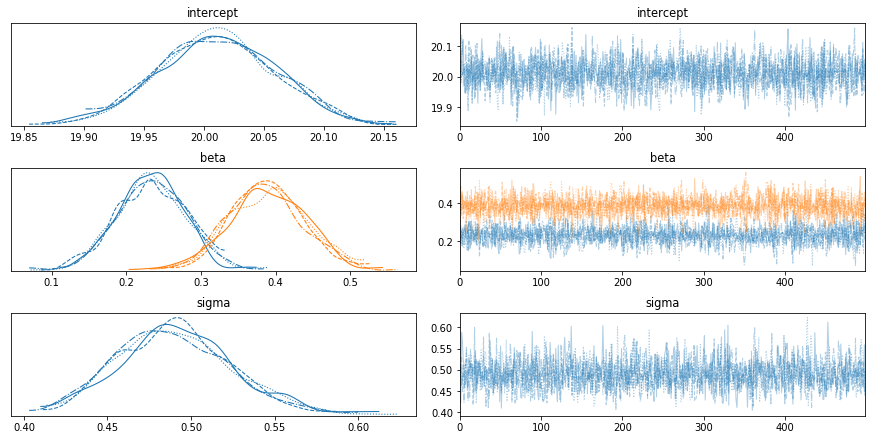

In [34]:
pm.traceplot(trace_500_ex);
plt.savefig('Posterior distributions of Synthetic Data - 500 draws.pdf')

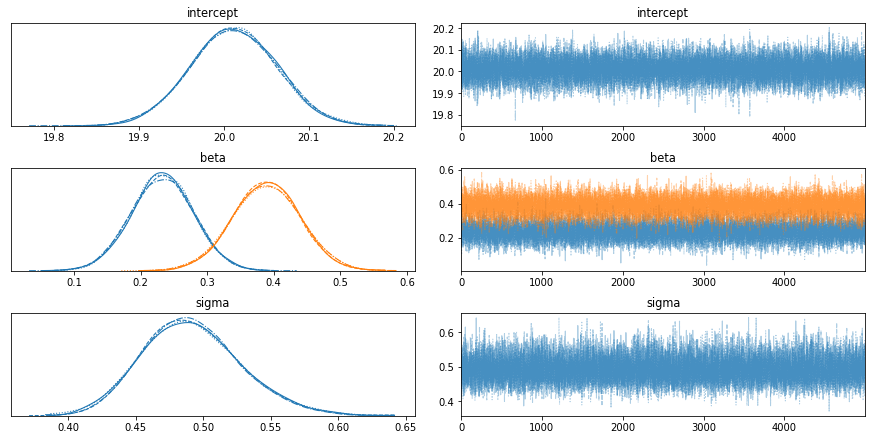

In [35]:
pm.traceplot(trace_5k_ex);
plt.savefig('Posterior distributions of Synthetic Data - 5k draws.pdf')

# Finding the MAP solution

It is the mode of the posterior distribution and is generally found using numerical optimization methods. But only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution.

Once again, close to actual parameters

In [36]:
pm.find_MAP(model = basic_model)

logp = -74.186, ||grad|| = 0.0016684: 100%|██████████| 13/13 [00:00<00:00, 1731.70it/s]  


{'intercept': array(20.01145104),
 'beta': array([0.23306499, 0.38918647]),
 'sigma': array(0.4780666)}

# Fitting Model to Housing Data

In [37]:
# instantiate model
house_model = pm.Model()

# Define target
y = data.SalePrice.values

# Define predictors
X = data[['GrLivArea','YearBuilt']].values
X1 = X[:,0]
X2 = X[:,1]

# with our model
with house_model:

    # Priors for unknown model parameters
    
    # Prior for intercept is still mean of observed 
    intercept = pm.Normal('intercept', mu=np.mean(y), sd=1000)
    
    # note shape = 2 parameter (it is a 2-vector)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Normal('sigma',mu = 1000, sd=50)

    # Expected value of outcome
    mu = intercept + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y)
    
    # instantiate sampler
    # Slice is a simpler sampler
    step = pm.Slice()

    # draw 500, the 5000 posterior samples
    trace_500_housing = pm.sample(500, step=step)
    trace_5k_housing = pm.sample(5000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 302.18draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:32<00:00, 684.55draws/s] 
The number of effective samples is smaller than 10% for some parameters.


# Plotting the distributions of the posteriors, with both 500 and 5,000 draws

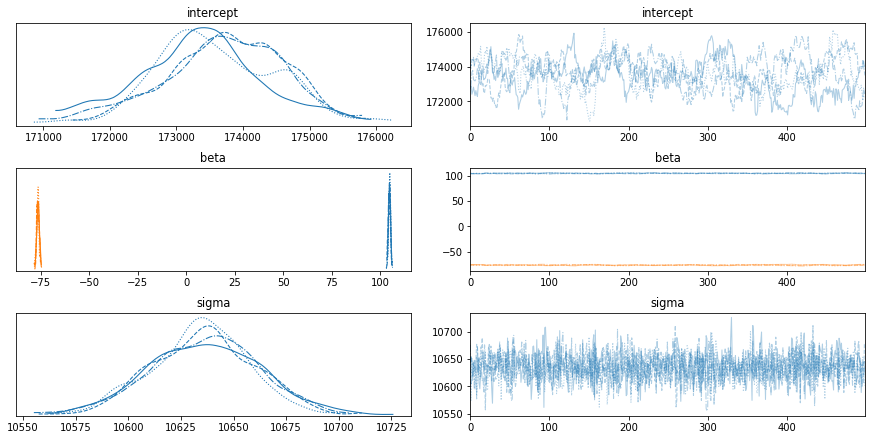

In [38]:
pm.traceplot(trace_500_housing);
plt.savefig('Posterior distributions of Housing Data - 500 draws.pdf')

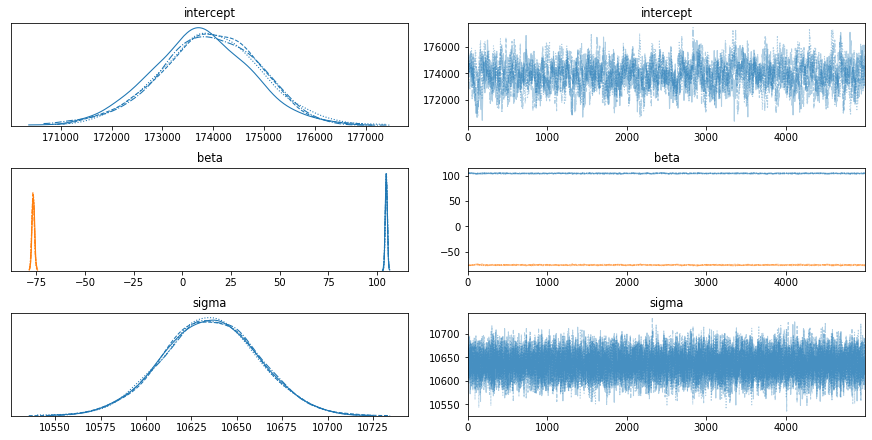

In [39]:
pm.traceplot(trace_5k_housing);
plt.savefig('Posterior distributions of Housing Data - 5k draws.pdf')

Raw observations

In [40]:
list(trace_500_housing.points())[:2]

[{'intercept': 172745.60349362117,
  'beta': array([104.02604861, -75.55282885]),
  'sigma': 10643.585656980282},
 {'intercept': 172877.6801144387,
  'beta': array([104.11425216, -75.58900551]),
  'sigma': 10654.627710873021}]